# First Parallel Scripts

*Author of homework: Alekandra Jamróz* 

Python Virtual Machine is a scalar program environment. It has only one execution thread.

If you need to execute a parallel algorithm, you need to use specific modules.
There are several modules (you can consult those modules in the follow link [https://wiki.python.org/moin/ParallelProcessing]).

The main problem is, most of the Parallel Modules, are OS dependant.

One of the more compatible module is the multiprocessing module [https://docs.python.org/3.6/library/multiprocessing.html].




In [ ]:
from multiprocessing import Pool
import multiprocessing as mp
import os
import numpy as np

To analyze our code we will import those two modules:
Time module, which allows us to make time calculae, like the time spend to execute our code.
cProfile, which allows us to profile and analyze our code behaviour

In [ ]:
import time
import cProfile

## Detect the number of cores in your computer

We can get the number of CPU cores available in the computer using the methods multiprocessing.cpu_count() or os.cpu_count().

In [ ]:
print ("Number of CPU cores counted with multiprocessing library: ", mp.cpu_count())
print ("Number of CPU cores counted with os library: ", os.cpu_count())

But, how many real cores contains our computer? 
* On linux:
On Linux, just look for "ht" on the "flags" line of /proc/cpuinfo. See for instance:
***
`grep '^flags\b' /proc/cpuinfo | tail -1`
***
or execute the command:
***
`lscpu` 
***
and check the field:
 
`Thread(s) per core:  2`

* On Windows:

On Windows, you can use the following command on PowerShell command line:
***
`WMIC CPU Get DeviceID,NumberOfCores,NumberOfLogicalProcessors`
***

Other option is opening the Task Manager, go to the **Performance** tab and select **CPU** from the left column. You’ll see the number of physical cores and logical processors on the bottom-right side.

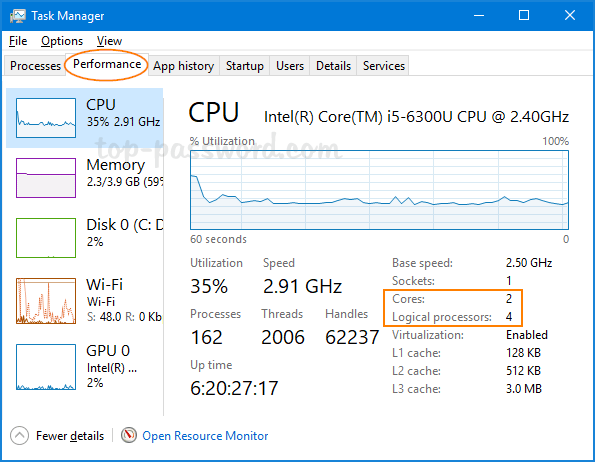


## PERSONAL LIBRARY
In the following cell we import the module where we will define the functions which we will execute in the parallel threads.

In [ ]:
import myfunctions as my

Everytime you make changes in the python file *myfunctions.py*, you have to reload them, to update the changes.

In [ ]:
import importlib
importlib.reload(my)

## INSTRUCTIONS
Before start to write code, we need to analyze our task and design several items:
* Select the block which we will distribute
* How we will split the work
* Design the distributed function
* Decide how we will distribute the source data
* Design how we will collect the results
* Design how we will coordinate/sinchronize the parallel tasks

### First simple code: 
Our Task:

Implement a function which calculates the square value of a large number of elements in a vector and sums them.

### Steps
1) Which parts we will distribute:
* We will not distribute the variables initialization
* Maybe intialize where the results will be stored (we will check and compare the time consuming)

2) How we will distribute the work
* In this case, we will use the multiprocess Pool object (https://docs.python.org/3.9/library/multiprocessing.html#multiprocessing.pool.Pool)
* Requisites/Parameters: 
    * processes - Number of process we will run in parallel simultaneously (if it is not provided, it will use the number returned by os.cpu_count())
    * initializer - the function which will be invoked if it will be executed in a separated execution environment (a separated environment). Not used today.
    * initializer parameters - array of elements who will be pass to the initializer function
    * max_tasks_per_child - Maximum number of tasks processed by each child process. Once the workers reach this number, will be destroyed and initialize a new one.
We need to control the number of processes, because the os.cpu_count() will return the number of execution threads, instead of the number of real cores.

3) Design the distributed function:
    Our atomic element is each one value in the long vector.

    We will distribute this *atomic* element to our distributed function.
    
    In our first distributed example (section 1a) our atomic element is a vector of size NUMELEMTS (10000000) divided by 64, which will be the total number of parallel proceseses we will run.
    
    For this case, the invoked function in parallel will be:
    <pre>
    def square_vector(idx):
        start_time = time.time()
        result = []
    
        data = np.random.rand(156250)
        for d in data:
            result.append(f(d))
        total_time=time.time()-start_time
        print("Hi, i am the task index {0}, time {1}".format(idx,total_time))
        return total_time    
    </pre>
    
    The second example, the distributed function will take a single element, and will return the square value of the element.
    <pre>
    def f(x):
      return x*x
    </pre>
    If we are running in a Windows OS, this function must be defined in a separated module (in our case, myfunctions.py module) and import in the main script.

    If we are running in a Linux/MacOS/\*NIX environment, can be defined in the main script. 

4) How we will distribute the source data:
    In this first example, we will pass use the **Pool.map** function to pass to the distributed function each one of the values in the data source vector. The problem is, the parameter passed to the **Pool.map** function must be an iterable variable, to fetch the parameters to pass to the function.
    
    In our case, we can use the original data vector as iterable parameter for the **Pool.map** function.
    
    For advanced functions, we can use global variables (always just to read values) or pass the original values to each one of the executor threads, in the initialization function in the **Pool** object.
   
5) How we will collect the results:
    The **Pool.map** returns ordered the returned value from the invoked function. 

    For advanced functions, we can use shared memory, taking care about the hazzards, and using semaphores or memory locks.
   
6) Design how we will coordinate/sinchronize the parallel tasks
    The **Pool.map** function synchronize the execution tasks, returning the results in ordered way. 
    
    If we use **Pool.map_async** function, we need to fetch the results data with the **VARIABLE.get(*timeout*)** method, where **VARIABLE** is the assigned variable to **Pool.map_Async** object.

Execute a program who allows to check the CPU consume:
* Linux: Open a terminal and execute **top** comand
* MacOS: Execute **Activity Monitor** and open **CPU Usage** window
* Windows: Open the Task Manager, go to the Performance tab and select CPU from the left column, then select **Open Resource Manager** in the bottom of the window.

Please, check the conditions in your computer and replace the \<FILL IN\> sentence with the correct command or value.

In [ ]:
IS_HT = True #True if your computer have the HyperThreading feature activated, False if not.
NUMBER_OF_REPORTED_CORES = mp.cpu_count() 
#Should be the number of real computational cores
if IS_HT:
    NUM_CORES = (int)(NUMBER_OF_REPORTED_CORES/2)
else:
    NUM_CORES = NUMBER_OF_REPORTED_CORES
    
print("Number of processes: {0}".format(NUM_CORES))

In [ ]:
%%time
# Generating the test data
NUMDATA = 10000000

#### 1a) First Parallel Task
We will generate 64 separate random vectors of size 156250 and calculate the square value of each element in the vector. The distributed function will identify the task index and print the individual time and the full taken time (we return time needed to execute code).

In [ ]:
NUM_PARALLELPROCS = 64
NUM_ELEMENTS_VECTOR = NUMDATA / NUM_PARALLELPROCS
print("The number of elements in the generated vector in the function my.square_vector is: {0}".format(NUM_ELEMENTS_VECTOR))

In [ ]:
idx = range(NUM_PARALLELPROCS)

In [ ]:
%%time
importlib.reload(my)
start_time = time.time()
with Pool(NUM_CORES) as p:
    result_t = p.map(my.square_vector, idx)
time_block = time.time() - start_time
print("Total optimized time {0} secs" .format(time_block))

In [ ]:
print("Total linear teorical time: {0}".format(np.sum(result_t)))

**Check the behaviour**:
The execution order is more or less random, but the returned results are ordered (thats says the documentation).<br/>
Remember this *feature* for further analysis.

Check the execution time changing the number of paralel tasks to 16,32 and 128 parallel tasks.
Compare the results, and anotate in the next cell.
Remember: you have to change the hardcode in the myfunctions.py to generate the correct number of elements in the inner vector.

In [ ]:
time_16 = 6.33
time_32 = 3.13
time_64 = 2.1
time_128 = 1.99

#### 1b) Serial execution (2 diferent versions)

In this section we will programme the baseline execution: execute in a linear, non paralllized code, same previous task, but using just one processor.

In [ ]:
DATA = np.random.rand(NUMDATA)

In [ ]:
results_serial_empty = []
results_serial_pre = np.zeros((NUMDATA,))
results_parallel = np.zeros((NUMDATA,))

In [ ]:
def serial_empty(numdata, data):
    result=[]
    for index in range(numdata):
        result.append(my.f(data[index]))
    return result

In [ ]:
%%time
start_time = time.time()
for x in range(10):
    result = serial_empty(NUMDATA, DATA)
time_serial_1 = time.time() - start_time
print("--- %s seconds ---" % (time_serial_1 / 10))

In [ ]:
def serial_execution(numdata, data):
    result=np.zeros((numdata,))
    for index in range(numdata):
        result[index]=my.f(data[index])
    return result

In [ ]:
%%time
start_time = time.time()
for x in range(10):
    result = serial_execution(NUMDATA,DATA)
time_serial_1 = time.time() - start_time
print("--- %s seconds ---" % (time_serial_1 / 10))

#### 1c) Fine granularity parallelized code
In this section, we implement the full, fine grain, parallelized code. In this case out atomic data is each element in the vector, and the function we will use is the one which calculates the square value.

In [ ]:
def parallel_execution(numdata, data):
    with Pool(NUM_CORES) as p:
        result = p.map_async(my.f, data)
        p.close()
        p.join()
    return result

Now we implement the execution in the parallel threads. Look, we invoke the f function implemented in the myfunctions module

In [ ]:
%%time
start_time = time.time()
for x in range(10):
    result = parallel_execution(NUMDATA,DATA)
time_serial_1 = time.time() - start_time
print("--- %s seconds ---" % (time_serial_1 / 10))

Check the performance.
Run several times, and play attention to the CPU Usage.
* With the first two codes, we just use only one python process at 100% CPU
* In the third code (parallelized code), we execute several python processes, but the performance is very poor.

We are distributing the execution, BUT with very poor performance. We need to investigate why (**Profiling**). 

In [ ]:
cProfile.run("serial_execution(NUMDATA,DATA)")

In [ ]:
cProfile.run("parallel_execution(NUMDATA,DATA)")

Lookup in the execution times and search for the method which takes more time to execute.<br/>

In the next cell implements a function who invokes the function used in the section 1a), and profiling them.<br>


In [ ]:
# Implent here the function to implement the block of section 1a) and profile them.
def section_1_a_block():
    importlib.reload(my)
    start_time = time.time()
    with Pool(NUM_CORES) as p:
        result_t = p.map(my.square_vector, idx)
    time_block = time.time() - start_time
    print("Total optimized time {0} secs" .format(time_block))
    

In [ ]:
cProfile.run("section_1_a_block()")

Compare the execution profiling tables and analyze the timing results. Do you remember the results are returned ordered? This is the critical condition here.<br>

Even, compare against the code in the section **1a)**, is not fair (even it is better). Check the code in all the cases and find the Not fair code.

### Analyse executions and compare

In section 1a, the more parallel processes were executed at the same time, the shortest final time was. We can see a significant difference between using 16, 32 and 64 processes. We can also see the difference between 64 and 128 parallel processes, but it is not so big. It's due to smaller vector sizes which were calculated faster. The best result achieved was below 2s, which I think is really nice result. 

In section 1c we implemented full parallised code which is supposed to run faster but the results were not so satisfying. Dividing the data to too small chunks could cause the programs to take longer time than it was necessary. Running the parallel_execution function 10 times took on average almost 8 minutes. It was really hard for CPU to run all of those programs, usage of CPU during the process increased significantly every time.
 
#### Extract conclusions about it

During data segmentation process we have to be carefull to choose correct amount of data for every piece of it. Decision about how to divide input data is really important if we want to achieve better results. We also should pay attention to our available hardware and custom the code to our possibilities.


# Second example code:

Program in a sequential and parallel execution.<br>
The task is implement the dot function between two vectors:<br>

<center>$dot(X,Y)=\sum_0^{N-1} x_n * y_n$<center>

Where $X$ and $Y$ are two vectors of length $N$, $x_n$, and $y_n$ are the elements at the $n_{th}$ position in each vector. 


In [ ]:
NUMDATA = 1000000

In [ ]:
data_X = np.random.rand(NUMDATA)
data_Y = np.random.rand(NUMDATA)

Because the **Pool.map** function receives just 1 paramiter, we will use the **Pool.starmap** function, which will receive a *tuple* of data, which contains the parameter values for the execution.<br>
To construct the tupple, we use the function *zip* function.<br>
<center>$zip(X,Y,Z) = [(x_0,y_0,z_0),(x_1,y_1,z_1),...,(x_{N-1},y_{N-1},z_{N-1})]$</center><br>

Where $X$,$Y$,$Z$ are vectors of size $N$, and $x_n$,$y_n$,$z_n$ are the values at the $n_{th}$ position in each one vectors.<br>
The $zip$ function can combine different kind of data any number of vectors.

The dot function, defined in the myfunctions module file, will receive 2 values and return their product:
<pre>
def dot(x,y):
    r = x*y
    return r
</pre>


In [ ]:
def serial_execution(x,y):
  results_serial = np.zeros((NUMDATA,))
  data_tuple = list(zip(x,y))
  for index in range(0, len(data_tuple)):
    results_serial[index] = my.dot(*data_tuple[index])
  return sum(results_serial)

In [ ]:
def parallel_execution(x,y):
  data_tuple = list(zip(x,y))
  with Pool(NUM_CORES) as p:
    results_dot = p.starmap(my.dot, data_tuple)
  return sum(results_dot)

In [ ]:
# homework function
def my_parallel_execution(x, y, num_cores):
    # splitting data to smaller vectors:
    x = np.array_split(x, num_cores)
    y = np.array_split(y, num_cores)
    tuples = list(zip(x,y))
    with Pool(num_cores) as p:
        results_dot = p.starmap(my.dot_product, tuples)
    return sum(results_dot)

In [ ]:
start_time = time.time()
results_serial = serial_execution(data_X, data_Y)
print("---Serial execution: %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()
results_parallel = parallel_execution(data_X,data_Y)
print("---Parallel execution: %s seconds ---" % (time.time() - start_time))

In [ ]:
# Checking the execution time of my function
start_time = time.time()
results_my_parallel = my_parallel_execution(data_X,data_Y, 32)
print("---My parallel execution: %s seconds ---" % (time.time() - start_time))

In [ ]:
print(results_serial)

In [ ]:
print(results_parallel)

In [ ]:
print(results_my_parallel)

Look the times... The parallel execution is not only bad. It is very bad!!

#Profiling
We will use the profiling tools to check our code and see where is the problem!

In [ ]:
cProfile.run("serial_execution(data_X,data_Y)")

In [ ]:
cProfile.run("parallel_execution(data_X,data_Y)")

In [ ]:
cProfile.run("my_parallel_execution(data_X,data_Y, 8)")

# HOMEWORK

Now, we have to improve the code!! 

* Implement a similar code like the one in the section 1a) to improve the dot product.
* The base line will be the serial execution, You should be able to execute the improved dot function faster than the serial function.

Tips:
* Split the data vector in a vector of vectors (with 32, 64 or 128 elements)
* Use this vector of vectors as the enumerable parameter for the **Pool.map** function.
* Write a function in myfunctions.py which calculates the dot product of those sub-vectors.
* Return the dot product between those subvectors.

## Analysis and conclusions!!

After running program several times, I clearly see, that running processes parallelly is much more efficient than their serial execution. With most appropriate parameters I managed to receive 3 times faster execution time, by using multiple cores instead of 1. Different processes numbers gave another results, so I checked how the function works with different parameters. It appeared that the best results are achieved when I use 8 of them - time needed to execute function was around 0,45s. For 16 it was 0.75s, for 32 - 1.33s and for 64 - 2.4s. I also tried running those processes using different dot product functions, but the differences were minor, so it didn't convince me to make more attempts.

During the cooperation with my partner we noticed also other thing. We would like to highlight the importance of taking into account the hardware on which the software is going to be run. The optimal code for one machine may be not optimal for other one due to hardware limitations. In this scenerio optimal amount of cores for my machine was 8, while for her it was just one. Even process of optimizing the code didn't make her parallel execution faster than the serial one.